**Henry Landay**

CS 252: Mathematical Data Analysis and Visualization

Spring 2024

Project 6: Supervised Learning and Handwritten Digit Recognition

In [79]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 2: RBF Network development dataset

The eventual goal is to train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9). Before doing this, you will use simpler data to develop and debug your network.

### 2a. Load and preprocess data

- Load in the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separate the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Perform min-max normalization on the train and test sets to normalize each data feature "separately".
    - Use the `min` and `max` values derived from the training set to normalize the test set. *This will ensure that identical feature values in the training and test sets get normalized to the same numeric value.*

**Tip:** It might be a good idea to write a few functions below so that you don't have a lot of duplicate code when processing train and test sets.

In [80]:
rbf_dev_train = pd.read_csv('data/rbf_dev_train.csv').to_numpy()
rbf_dev_test = pd.read_csv('data/rbf_dev_test.csv').to_numpy()

y_train = rbf_dev_train[:, 2].astype(int)
y_test = rbf_dev_test[:, 2].astype(int)

rbf_dev_train = rbf_dev_train[:, :2]
rbf_dev_test = rbf_dev_test[:, :2]

min_train = np.min(rbf_dev_train, axis=0)
max_train = np.max(rbf_dev_train, axis=0)

rbf_dev_train =  (rbf_dev_train - min_train) / (max_train - min_train)
rbf_dev_test =  (rbf_dev_test - min_train) / (max_train - min_train)

#### Preprocessing test code

The following test code is a good sanity check, but you are encouoraged to do additional testing to make sure that your preprocessing pipeline is working properly.

##### Check dtypes

In [81]:
print(f'Your training set is an ndarray? {isinstance(rbf_dev_train, np.ndarray)}')
print(f'Your training classes is an ndarray? {isinstance(y_train, np.ndarray)}')
print(f'Your test set is an ndarray? {isinstance(rbf_dev_test, np.ndarray)}')
print(f'Your test classes is an ndarray? {isinstance(y_test, np.ndarray)}')

Your training set is an ndarray? True
Your training classes is an ndarray? True
Your test set is an ndarray? True
Your test classes is an ndarray? True


##### Check shapes

In [82]:
print(f'Your training set shape is {rbf_dev_train.shape} and should be (1600, 2).')
print(f'Your training classes shape is {y_train.shape} and should be (1600,).')
print(f'Your test set shape is {rbf_dev_test.shape} and should be (400, 2).')
print(f'Your test classes shape is {y_test.shape} and should be (400,).')

Your training set shape is (1600, 2) and should be (1600, 2).
Your training classes shape is (1600,) and should be (1600,).
Your test set shape is (400, 2) and should be (400, 2).
Your test classes shape is (400,) and should be (400,).


##### Check dtypes (detailed)

In [83]:
print(f'Your training set is an float? {isinstance(rbf_dev_train[0,0], float)}')
print(f'Your training classes is an int? {isinstance(y_train[0], np.int64)}')
print(f'Your test set is an float? {isinstance(rbf_dev_test[0,0], float)}')
print(f'Your test classes is an int? {isinstance(y_test[0], np.int64)}')

Your training set is an float? True
Your training classes is an int? True
Your test set is an float? True
Your test classes is an int? True


##### Check normalization (detailed)

In [84]:
print(f'Your training set mins/maxs: {rbf_dev_train.min(axis=0)}/{rbf_dev_train.max(axis=0)}\nand should be                [0. 0.]/[1. 1.]')
print(f'Your test set mins/maxs: {rbf_dev_test.min(axis=0)}/{rbf_dev_test.max(axis=0)}\nand should be            [0.02038 0.01194]/[0.99805 0.98749]')

print(f'Training values look ok? {len(np.unique(rbf_dev_train)) > 2}')
print(f'Test values look ok? {len(np.unique(rbf_dev_test)) > 2}')

Your training set mins/maxs: [0. 0.]/[1. 1.]
and should be                [0. 0.]/[1. 1.]
Your test set mins/maxs: [0.02038 0.01194]/[0.99805 0.98749]
and should be            [0.02038 0.01194]/[0.99805 0.98749]
Training values look ok? True
Test values look ok? True


### 2b. Plot data

Create a scatter plot of the training data in the cell below.

- Color code each sample by its output class.
- Make the aspect ratio (height and width) of the x and y axes in the figure equal, otherwise the plot may look distorted.

If everything is working properly, you should see a jack-o-lantern whose eyes, noise, mouth, and stem are colored differently than the rest of the face.

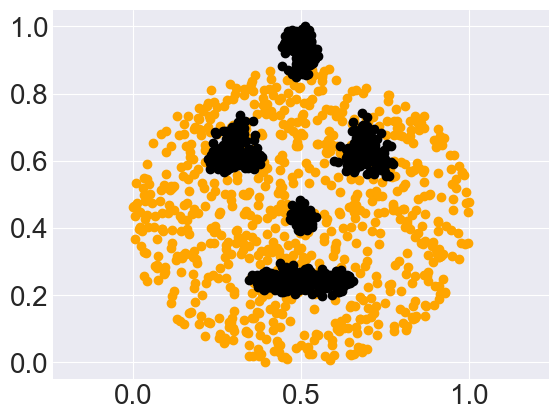

In [85]:
colors=['orange', 'black']
for i in range(2):
    plt.scatter(rbf_dev_train[y_train==i][:, 0], rbf_dev_train[y_train==i][:, 1], color=colors[i])
plt.axis('equal') 
plt.show()

## Task 3: Radial basis function neural network

In [86]:
from rbf_net import RBF_Net

### 3a. Network initalization

You will use K-means to initialize the RBF hidden layer prototypes and sigmas.

1. Copy over your `kmeans.py` from your previous project. If your K-means clustering code isn't working properly, you may use `scipy` functions in this project instead, but at a 1 point reduction. Check out `scipy.cluster.vq.kmeans`.

2. Implement the method templates in `rbf.py` that initialize the hidden layer of the neural network:
    - Finish writing the constructor
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Compute the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Use K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [176]:
from kmeans import KMeans

#### Test `avg_cluster_dist`

In [88]:
np.random.seed(0)

# N = 10 samples, M = 5 features
test_data = np.random.normal(size=(10, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_assignments = np.random.randint(low=0, high=4, size=(10,))
kmeansObj = KMeans()

test_net = RBF_Net(4, 3)
print(f'Number of hidden units in your net is {test_net.get_num_hidden_units()} and should be 4')
print(f'Number of output units in your net is {test_net.get_num_output_units()} and should be 3')
test_clust_mean_dists = test_net.avg_cluster_dist(test_data, test_centroids, test_assignments, kmeansObj)

print(f'Your avg within cluster distances are\n{test_clust_mean_dists} and should be\n[2.23811 3.94891 3.12267 3.4321]')

Number of hidden units in your net is 4 and should be 4
Number of output units in your net is 3 and should be 3
Your avg within cluster distances are
[2.23811 3.94891 3.12267 3.4321 ] and should be
[2.23811 3.94891 3.12267 3.4321]


#### Test `initialize`

In [89]:
np.random.seed(0)
test_net.initialize(test_data)

print(f'Your prototypes have shape {test_net.get_prototypes().shape} and the shape should be (4, 5).')
print(f'Your hidden unit sigmas have shape {test_net.sigmas.shape} and the shape should be (4,).')

Your prototypes have shape (4, 5) and the shape should be (4, 5).
Your hidden unit sigmas have shape (4,) and the shape should be (4,).


#### Test initialization methods

In the cell below, write test code for your RBF network initialization:
- Create a new RBF network with 7 hidden units and 2 output classes.
- Call the `initalize` method on it, passing in the training data.
- Create a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

You should see fairly evenly distributed prototypes, with one in most, if not all, "pockets" of samples belonging to a single class.

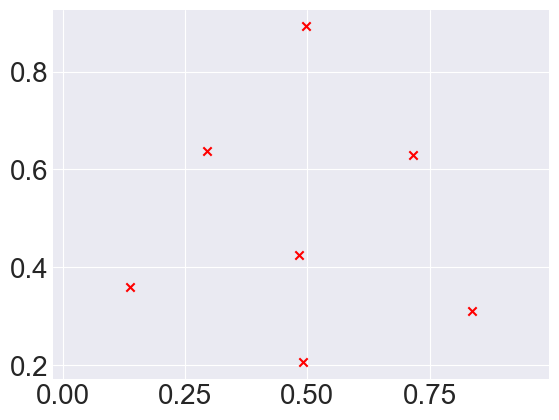

In [90]:
rbf = RBF_Net(7, 2)
rbf.initialize(rbf_dev_train)
colors=['orange', 'black']
prototypes = rbf.get_prototypes()
plt.scatter(prototypes[:, 0], prototypes[:, 1], color='red', marker='x', label='Prototypes')
plt.axis('equal') 
plt.show()

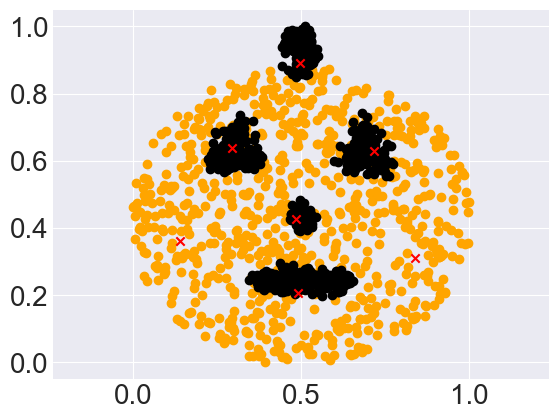

In [91]:
for i in range(2):
    plt.scatter(rbf_dev_train[y_train==i][:, 0], rbf_dev_train[y_train==i][:, 1], color=colors[i])
plt.scatter(prototypes[:, 0], prototypes[:, 1], color='red', marker='x', label='Prototypes')
plt.axis('equal') 
plt.show()

### 3b. Questions

**Question 7:** Will the prototypes enable the RBF network to learn to classify the dataset well? Why or why not?

**Answer 7:** 
I think the prototypes will enable the RBF network to learn to classify the dataset well because the clusters are well distributed which means they will cover all of the data and they cover each of the clusters meaning that each cluster is accounted for.

### 3c. Compute hidden and output layer activations

Implement the following methods so that you can train your RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [92]:
np.random.seed(1)

# N = 3 samples, M = 5 features
test_data = np.random.normal(size=(3, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Your hidden layer activation is\n{test_h_act}\n\nand should be')
print('[[0.      0.      0.00009 0.00033]\n [0.00013 0.      0.00004 0.00014]\n [0.      0.      0.      0.00001]]')

Your hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]

and should be
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


#### Test output_act

In [93]:
test_out_act = test_net.output_act(test_h_act)
print(f'Your output layer activation is\n{test_out_act}\n\nand should be')
print('[[-0.79555 -0.17162  0.38867]\n [-0.79545 -0.17189  0.38875]\n [-0.79534 -0.17188  0.3888 ]]')

Your output layer activation is
[[-0.79555 -0.17162  0.38867]
 [-0.79545 -0.17189  0.38875]
 [-0.79534 -0.17188  0.3888 ]]

and should be
[[-0.79555 -0.17162  0.38867]
 [-0.79545 -0.17189  0.38875]
 [-0.79534 -0.17188  0.3888 ]]


### 3d. Learn network weights using linear regression

To train your RBF network, you will need to find optimal weights between hidden and output layer neurons to allows your network to accurately classify the training data (i.e. learn from the data). An efficient solution is to use linear regression to solve a least square problem: minimizing the squared difference between the *hidden layer activations* and the *true data classes*.

To solve for the weights/unknown coefficients, you will use implement a SVD-based linear regression solver, which is both fast and numerically accurate. In the equation $Ac = y$ The weights $c$ can be solved via the following matrix equation: $$c = A^+y$$ where $A^+$ is the pseudo inverse of the matrix of RBF hidden layer activations $A$ (*data matrix*) and the correct classes $y$.

#### If you get here before we cover the SVD-based linear regression solver in lecture:

In `rbf.py`, implement:
- `linear_regression(A, y)`. Use the Scipy solver for now: `scipy.linalg.lstsq`. Recall, this was one of your supported solvers in the Linear Regression project.

Skip over **Test: Pseudo inverse** below.

#### After we cover the SVD-based linear regression solver in lecture:

In `rbf.py`, implement:
1. `pseudo_inverse(A)`. Then run test code below.
2. `linear_regression(A, y)`. Replace `scipy.linalg.lstsq` with your own SVD-based linear regression solver.

#### Test: Pseudo inverse

In [94]:
np.random.seed(0)
test_A = np.random.rand(10, 5)
net = RBF_Net(num_classes=3, num_hidden_units=5)
test_A_plus = net.pseudo_inverse(test_A)
print(f'The mean abs error between your pseudo inverse of A and the true one is:\n{np.sum(np.abs(test_A_plus - np.linalg.pinv(test_A)))} and should be 0.0')

The mean abs error between your pseudo inverse of A and the true one is:
0.0 and should be 0.0


#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

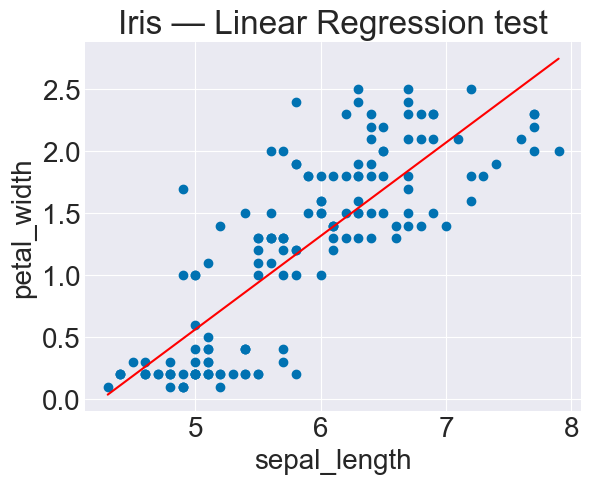

In [95]:
df = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = iris_c[0] + line_x*iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y, c='r')
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 3e. Train your RBF Network

Implement the following methods then train your neural network! In the cell below, train a RBF network with 10 hidden units on the RBF dev dataset. **If everything is working, you should get >=88% accuracy on the training set and >=89% on the test set.**

- `train`: Determine the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Use trained network (after learning) to predict the class of data.


In [96]:
rbf_net = RBF_Net(num_hidden_units=10, num_classes=4)
rbf_net.train(rbf_dev_train, y_train)
train_preds = rbf_net.predict(rbf_dev_train)
test_preds = rbf_net.predict(rbf_dev_test)
train_accuracy = rbf_net.accuracy(y_train, train_preds)
test_accuracy = rbf_net.accuracy(y_test, test_preds)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 88.88%
Test Accuracy: 90.75%


## Task 4: Handwritten digit classification: MNIST data

You will train a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

The goal is to train your network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### 4a. Load in and look at MNIST dataset

- Use the numpy function `load` to load in the MNIST train/test data and the associated class labels.
- Create a 5x5 grid showing the first 25 images in the dataset. It should "look good" (e.g. turn off tick marks).

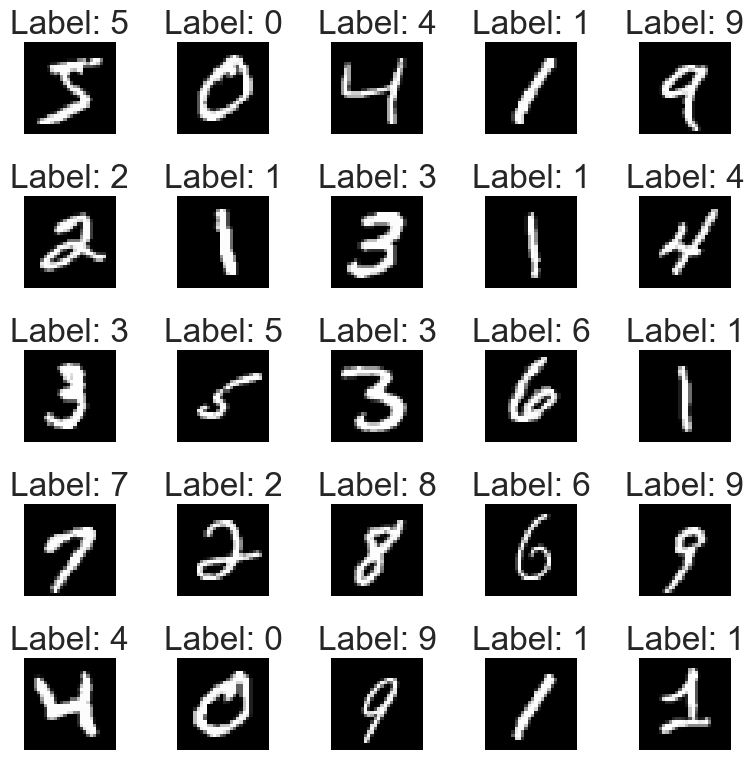

In [97]:
# loadin
train_x = np.load('data/mnist_train_data.npy')
train_y = np.load('data/mnist_train_labels.npy')

test_x = np.load('data/mnist_test_data.npy')
test_y = np.load('data/mnist_test_labels.npy')

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Label: {train_y[i]}')
plt.tight_layout()
plt.show()

In [98]:
print(f'Your training set shape is {train_x.shape} and should be (60000, 28, 28).')
print(f'Your training classes shape is {train_y.shape} and should be (60000,).')
print(f'Your test set shape is {test_x.shape} and should be (10000, 28, 28).')
print(f'Your test classes shape is {test_y.shape} and should be (10000,).')

Your training set shape is (60000, 28, 28) and should be (60000, 28, 28).
Your training classes shape is (60000,) and should be (60000,).
Your test set shape is (10000, 28, 28) and should be (10000, 28, 28).
Your test classes shape is (10000,) and should be (10000,).


### 4b. Preprocess data

- Flatten non-leading dimensions of the train and test sets. For example, the training set should go from (60000, 28, 28) to (60000, 784). **Do not hard code this!** Your code should work for any data with three dimensions.
- Normalize so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [99]:
def pre_process(data):
    x, y, z = data.shape
    new = data.reshape(x, y*z)
    max = np.max(new)
    min = np.min(new)
    new = (new - min) / (max - min)
    return new

x_train_new = pre_process(train_x)
x_test_new = pre_process(test_x)

print("Shape of x_train_new:", x_train_new.shape)
print("Shape of x_test_new:", x_test_new.shape)
print()
print("Max of x_train_new:", np.max(x_train_new))
print("Min of x_train_new:", np.min(x_train_new))
print()
print("Max of x_test_new:", np.max(x_test_new))
print("Min of x_test_new:", np.min(x_test_new))

Shape of x_train_new: (60000, 784)
Shape of x_test_new: (10000, 784)

Max of x_train_new: 1.0
Min of x_train_new: 0.0

Max of x_test_new: 1.0
Min of x_test_new: 0.0


### 4c. Train and assess performance on MNIST

Train a RBF network on MNIST. **Your goal is to get >=90% accuracy on both train and test sets.**

**Tips:**
- Depending on your laptop or machine you are using, training could take many hours if you use the full 60,000 sample training set. Select a subset to train on (e.g. ~3000) that takes a reasonable amount of time (e.g. minutes). You should be able to hit your accuracy goals without too much data, effort, or time.
- Do not pare down the test set (i.e. it should remain at 10,000 samples).
- Use the code below to visualize your hidden layer prototypes to help with debugging (assumes your network is called `mnist_net`). Your prototypes should look like images of certain digits, perhaps a little blurrier.

In [148]:
np.random.seed(0)
mnist_net = RBF_Net(100, 10)
mnist_net.train(x_train_new[:3000, :], train_y[:3000])

pred_train = mnist_net.predict(x_train_new[:3000, :])
pred_test = mnist_net.predict(x_test_new)

acc_train = mnist_net.accuracy(train_y[:3000], pred_train)
acc_test = mnist_net.accuracy(test_y, pred_test)

print("The accuracy on the training set is:", acc_train)
print("The accuracy on the test set is:", acc_test)

The accuracy on the training set is: 0.917
The accuracy on the test set is: 0.9002


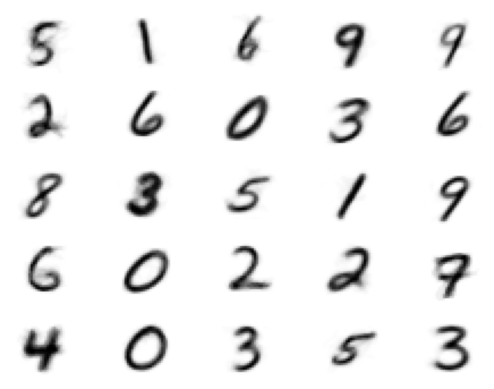

In [149]:
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])

cols = rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(prototypes[i*rows + j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

### 4d. Questions

**Question 8:** Which part of the training process takes the longest?

**Question 9:** What accuracy did you achieve on the training set? List all parameters that you needed to set (e.g. number of training samples, number hidden units, etc).

**Question 10:** Using the same parameters to get the training accuracy that you reported in Question 3, what test accuracy did you achieve?

**Answer 8:** 
 The part that takes the longest is performing the linear regression when we train the algorithm.

**Answer 9:** 
 I achieved an accuracy of just under 92% on the training set. I used 3000 training samples and 100 hidden units to get this accuracy.

**Answer 10:** I achieved a test accuracy of just over 90%.

### 4e. Visualize prototypes using network weights

Now that you've trained the network to recognize handwritten digits, let's visualize the dominant factors that the network learns to rely on to make each prediction.

Create a 10 x 5 plot showing images of the 5 "most influential hidden layer prototypes" that contribute to predicting each of the 10 output classes. These are defined as the hidden layer prototypes that have the 5 largest weights (in absolute value) going from the hidden layer to the output layer. *Recall that each hidden unit prototype has the same shape as a single data sample so each image in your grid should be 28x28.*

**Note:** We want to remove/ignore the weight for bias neuron from this analysis.

(101, 10)
(100, 10)
(100, 28, 28)
[ 7 37 47 44 45]
[ 1 94 74 45 33]
[28 68 45  3 82]
[30 41  8 78 88]
[67 62 95 70 20]
[44 23 45 24 84]
[83 15 28 64  0]
[62 99  0 58 14]
[30 65 84 10 45]
[67  0 69 78 53]


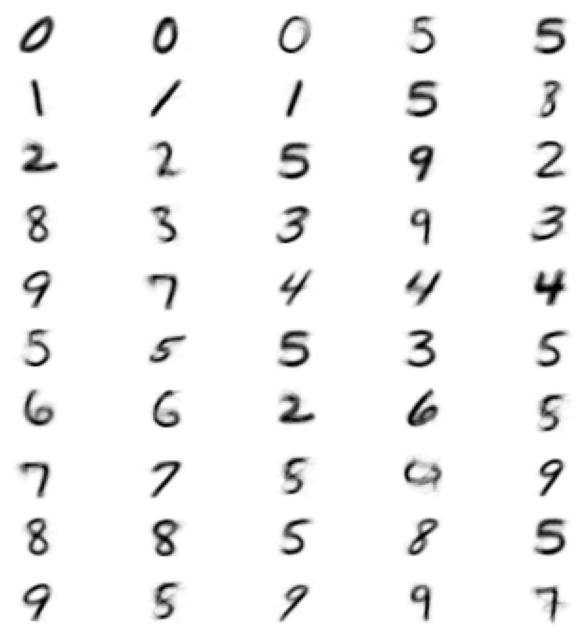

In [155]:
fig, axes = plt.subplots(10, 5, figsize=(8, 8))
print(mnist_net.wts.shape)
wts = mnist_net.wts[1:, :]
print(wts.shape)
print(prototypes.shape)
for i in range(wts.shape[1]):
    top_five_indices = np.flip(np.argsort(np.abs(wts[:, i])))
    top_five_indices = top_five_indices[:5]
    print(top_five_indices)
    top_five = mnist_net.prototypes[top_five_indices]
    for j in range(5):
        axes[i, j].imshow(top_five[j].reshape(28,28))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])


### 4f. Questions

**Question 11:** Interpret what each row of your 10x5 grid of images means. Did any of the top prototypes surprise you?

**Answer 11:** 

Each row of 10x5 grid corresponds to the prototypes that have the largest weights going into each class. What this means is that each item in that row has the greatest impact on how big that class' neural activation is. I was very surprised the prototypes because in every row there are prototypes that I can plainly see have different classes than the class that gives them the greatest weight.

## Task 5: Comparison between RBF Neural Network and KNN on MNIST

The goal of this task is to compare the classification results produced by your RBF neural network and KNN classifiers.

In [177]:
from knn import KNN

### 5a. Accuracy comparison

In the 1st cell below:
- train your KNN classifier with K=1 (i.e. nearest neighbor) on the MNIST training set.
- Print out the accuracy achieved by KNN on the first 500 samples of the test set.

In the 2nd cell below:
- Print out the accuracy achieved by your RBF neural network (that you trained above) on the first 500 samples of the test set.

In [168]:
# KNN: 500 samples
knn = KNN(num_classes=10)
knn.train(x_train_new, train_y)
knn_pred = knn.predict(x_test_new[:500], 1)
acc1 = knn.accuracy(y=test_y[:500], y_pred=knn_pred)
acc1

0.966

In [169]:
# KNN: 1000 samples
knn = KNN(num_classes=10)
knn.train(x_train_new, train_y)
knn_pred = knn.predict(x_test_new[:1000], 1)
acc2 = knn.accuracy(y=test_y[:1000], y_pred=knn_pred)
acc2

0.962

In [170]:
# KNN: 2000 samples
knn = KNN(num_classes=10)
knn.train(x_train_new, train_y)
knn_pred = knn.predict(x_test_new[:2000], 1)
acc3 = knn.accuracy(y=test_y[:2000], y_pred=knn_pred)
acc3

0.96

In [194]:
# RBF: 500 samples
rbf_pred = mnist_net.predict(x_test_new[:500, :])
acc4 = mnist_net.accuracy(y=test_y[:500], y_pred=rbf_pred)
acc4

0.886

In [195]:
# RBF: 1000 samples
rbf_pred = mnist_net.predict(x_test_new[:1000, :])
acc5 = mnist_net.accuracy(y=test_y[:1000], y_pred=rbf_pred)
acc5

0.879

In [196]:
# RBF: 2000 samples
rbf_pred = mnist_net.predict(x_test_new[:2000, :])
acc6 = mnist_net.accuracy(y=test_y[:2000], y_pred=rbf_pred)
acc6

0.8715

### 5b. Questions

**Question 12:** What two things jump out to you about the two supervised learning models? (*Hint: Try increasing the number of test samples to 1000 or 2000*).

**Answer 12:** 
What jumps out to me the most is that the KNN predictions are better than the RBF predictions in terms of accuracy and adding testing samples does not change its accuracy. RBF on the other hand is not as good at predicting and it gets slightly worse as you increase the number of testing samples.

### 5c. Implement confusion matrix

Implement the `confusion_matrix` method in the `Classifer` class then test it below.

#### Test confusion matrix

In [179]:
from classifier import Classifier as Classifer

In [181]:
num_test_classes = 4
np.random.seed(0)
y_true_cf = np.random.randint(low=0, high=num_test_classes, size=(100,))
y_test_cf = np.random.randint(low=0, high=num_test_classes, size=(100,))

test_classifier = Classifer(num_classes=num_test_classes)
test_cm = test_classifier.confusion_matrix(y_true_cf, y_test_cf)

print(f'Your confusion matrix is:\n{test_cm} and it should be:')
print('''[[ 8.  3.  6.  8.]
 [ 5.  5. 10.  4.]
 [ 3.  3.  7.  6.]
 [10.  7.  6.  9.]]''')

Your confusion matrix is:
[[ 8.  3.  6.  8.]
 [ 5.  5. 10.  4.]
 [ 3.  3.  7.  6.]
 [10.  7.  6.  9.]] and it should be:
[[ 8.  3.  6.  8.]
 [ 5.  5. 10.  4.]
 [ 3.  3.  7.  6.]
 [10.  7.  6.  9.]]


### 5d. Inspect misclassifications

To better understand the misclassifications made by the two classifiers, in the cell below print out a confusion matrix for each classifier based on the 1st 500 test set samples.

*Optional:* If you like, you can visualize the confusion matrix with a heatmap. I would suggest superimposing the confusion matrix values on the heatmap so you see not only the color but the numeric count at each location.

In [215]:
knn_cm = mnist_net.confusion_matrix(test_y[:500], knn_pred[:500])
rbf_cm = mnist_net.confusion_matrix(test_y[:500], rbf_pred[:500])
print("KNN: \n", knn_cm)
print("\nRBF: \n", rbf_cm)

KNN: 
 [[42.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 67.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 53.  0.  0.  0.  0.  1.  1.  0.]
 [ 0.  0.  0. 42.  0.  1.  0.  2.  0.  0.]
 [ 0.  1.  0.  0. 52.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  1.  0. 49.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0. 41.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0. 48.  0.  0.]
 [ 1.  0.  0.  0.  0.  1.  0.  0. 38.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  1.  1. 51.]]

RBF: 
 [[42.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 67.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 48.  1.  1.  0.  0.  3.  2.  0.]
 [ 0.  0.  1. 38.  0.  2.  1.  3.  0.  0.]
 [ 0.  0.  0.  0. 46.  0.  3.  0.  0.  6.]
 [ 1.  0.  0.  2.  1. 45.  1.  0.  0.  0.]
 [ 2.  0.  1.  0.  1.  2. 37.  0.  0.  0.]
 [ 0.  2.  1.  0.  2.  0.  0. 43.  0.  1.]
 [ 0.  0.  0.  3.  1.  0.  0.  2. 34.  0.]
 [ 0.  1.  1.  2.  3.  0.  0.  2.  2. 43.]]


### 5e. Questions

**Question 13:** Identify specific cases among the most common confusions that each classifier makes. Why do they make sense or do not make sense to you?

**Answer 13:** 
The most common casses of mistakes seem to be between 8s and 3s, 2s and 7s, and 4s and 9s. This makes sense because the general shapes of these numbers are similar.

## Extensions

### a. Reminder: AI Policy

The goal of extensions is to learn and create something new beyond the base project that excites you. To serve this goal and out of fairness to your hardworking classmates, **AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions.** This includes both written analysis, plotting, and code. We will only grade **your** work, not an AI's. **We will stop grading your project if we notice AI-generated content (to any capacity).**

### b. Guidelines

To receive credit for any extension, you must:
1. Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
2. **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
3. Include (*labeled!*) plots and/or numbers to present your results.
4. Write up your extensions below or in a separate notebook.
5. Give kudos to all sources, including anyone that you consulted.

### c. Suggestions

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

The ideas below are **suggested** extensions — feel free to go in another direction related to this project that is not listed!

### 1) Improve performance on MNIST with PCA

Using all 768 features (pixels) in each image may not be very helpful for classification. For example, pixels around the border are almost always white. Transform the dataset(s) using PCA to compress the number of features before training your RBF network. Experiment with PCA to improve classification accuracy and runtime performance.

### 2) Visualize network predictions

Make visualizations to show and interpret the MNIST network predictions. Lots of possibilities, here are a few specific ideas:
- Make show a grid of test samples labeled with their predicted digit.
- Analyze if the network performance favors accuracy for certain digits and not others.
- Are errors on certain classes correlated in any way? Does it depend on their digit similarity (e.g. 1 looks like a 7, but not a 0).
- Make and interpret a confusion plot.

### 3) Explore parameter space

When training your RBF network on MNIST, you had to pick some parameter values to use by hand. Pick one or more parameters and systematically vary them to quantify their effect on accuracy and simulation time.

### 4) Initialization schemes

Research, test out, and quantify the performance of different techniques to set the hidden unit prototypes and sigmas. For example, an alternative way to initialize the prototypes is to perform K-means to cluster each class *separately*. 

### 5) Other datasets

Use your RBF network to classify other datasets.

### 6) Analyze the trained network

Run simulations then analyze and interpret the results. Here are some ideas:
- Visualize and analyze how the prototypes influence the classification results.
- Visualize and analyze how the network weights influence the classification results.

# Extension

In [274]:
def extension(images, labels_true, labels_pred, rows, cols, figsize=(20, 20)):
    # using subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            axes[i, j].imshow(images[index].reshape(28, 28), cmap='gray') 
            axes[i, j].set_title(f'True: {labels_true[index]}\nPredicted: {labels_pred[index]}', fontsize=20)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            
    plt.tight_layout()
    plt.show()


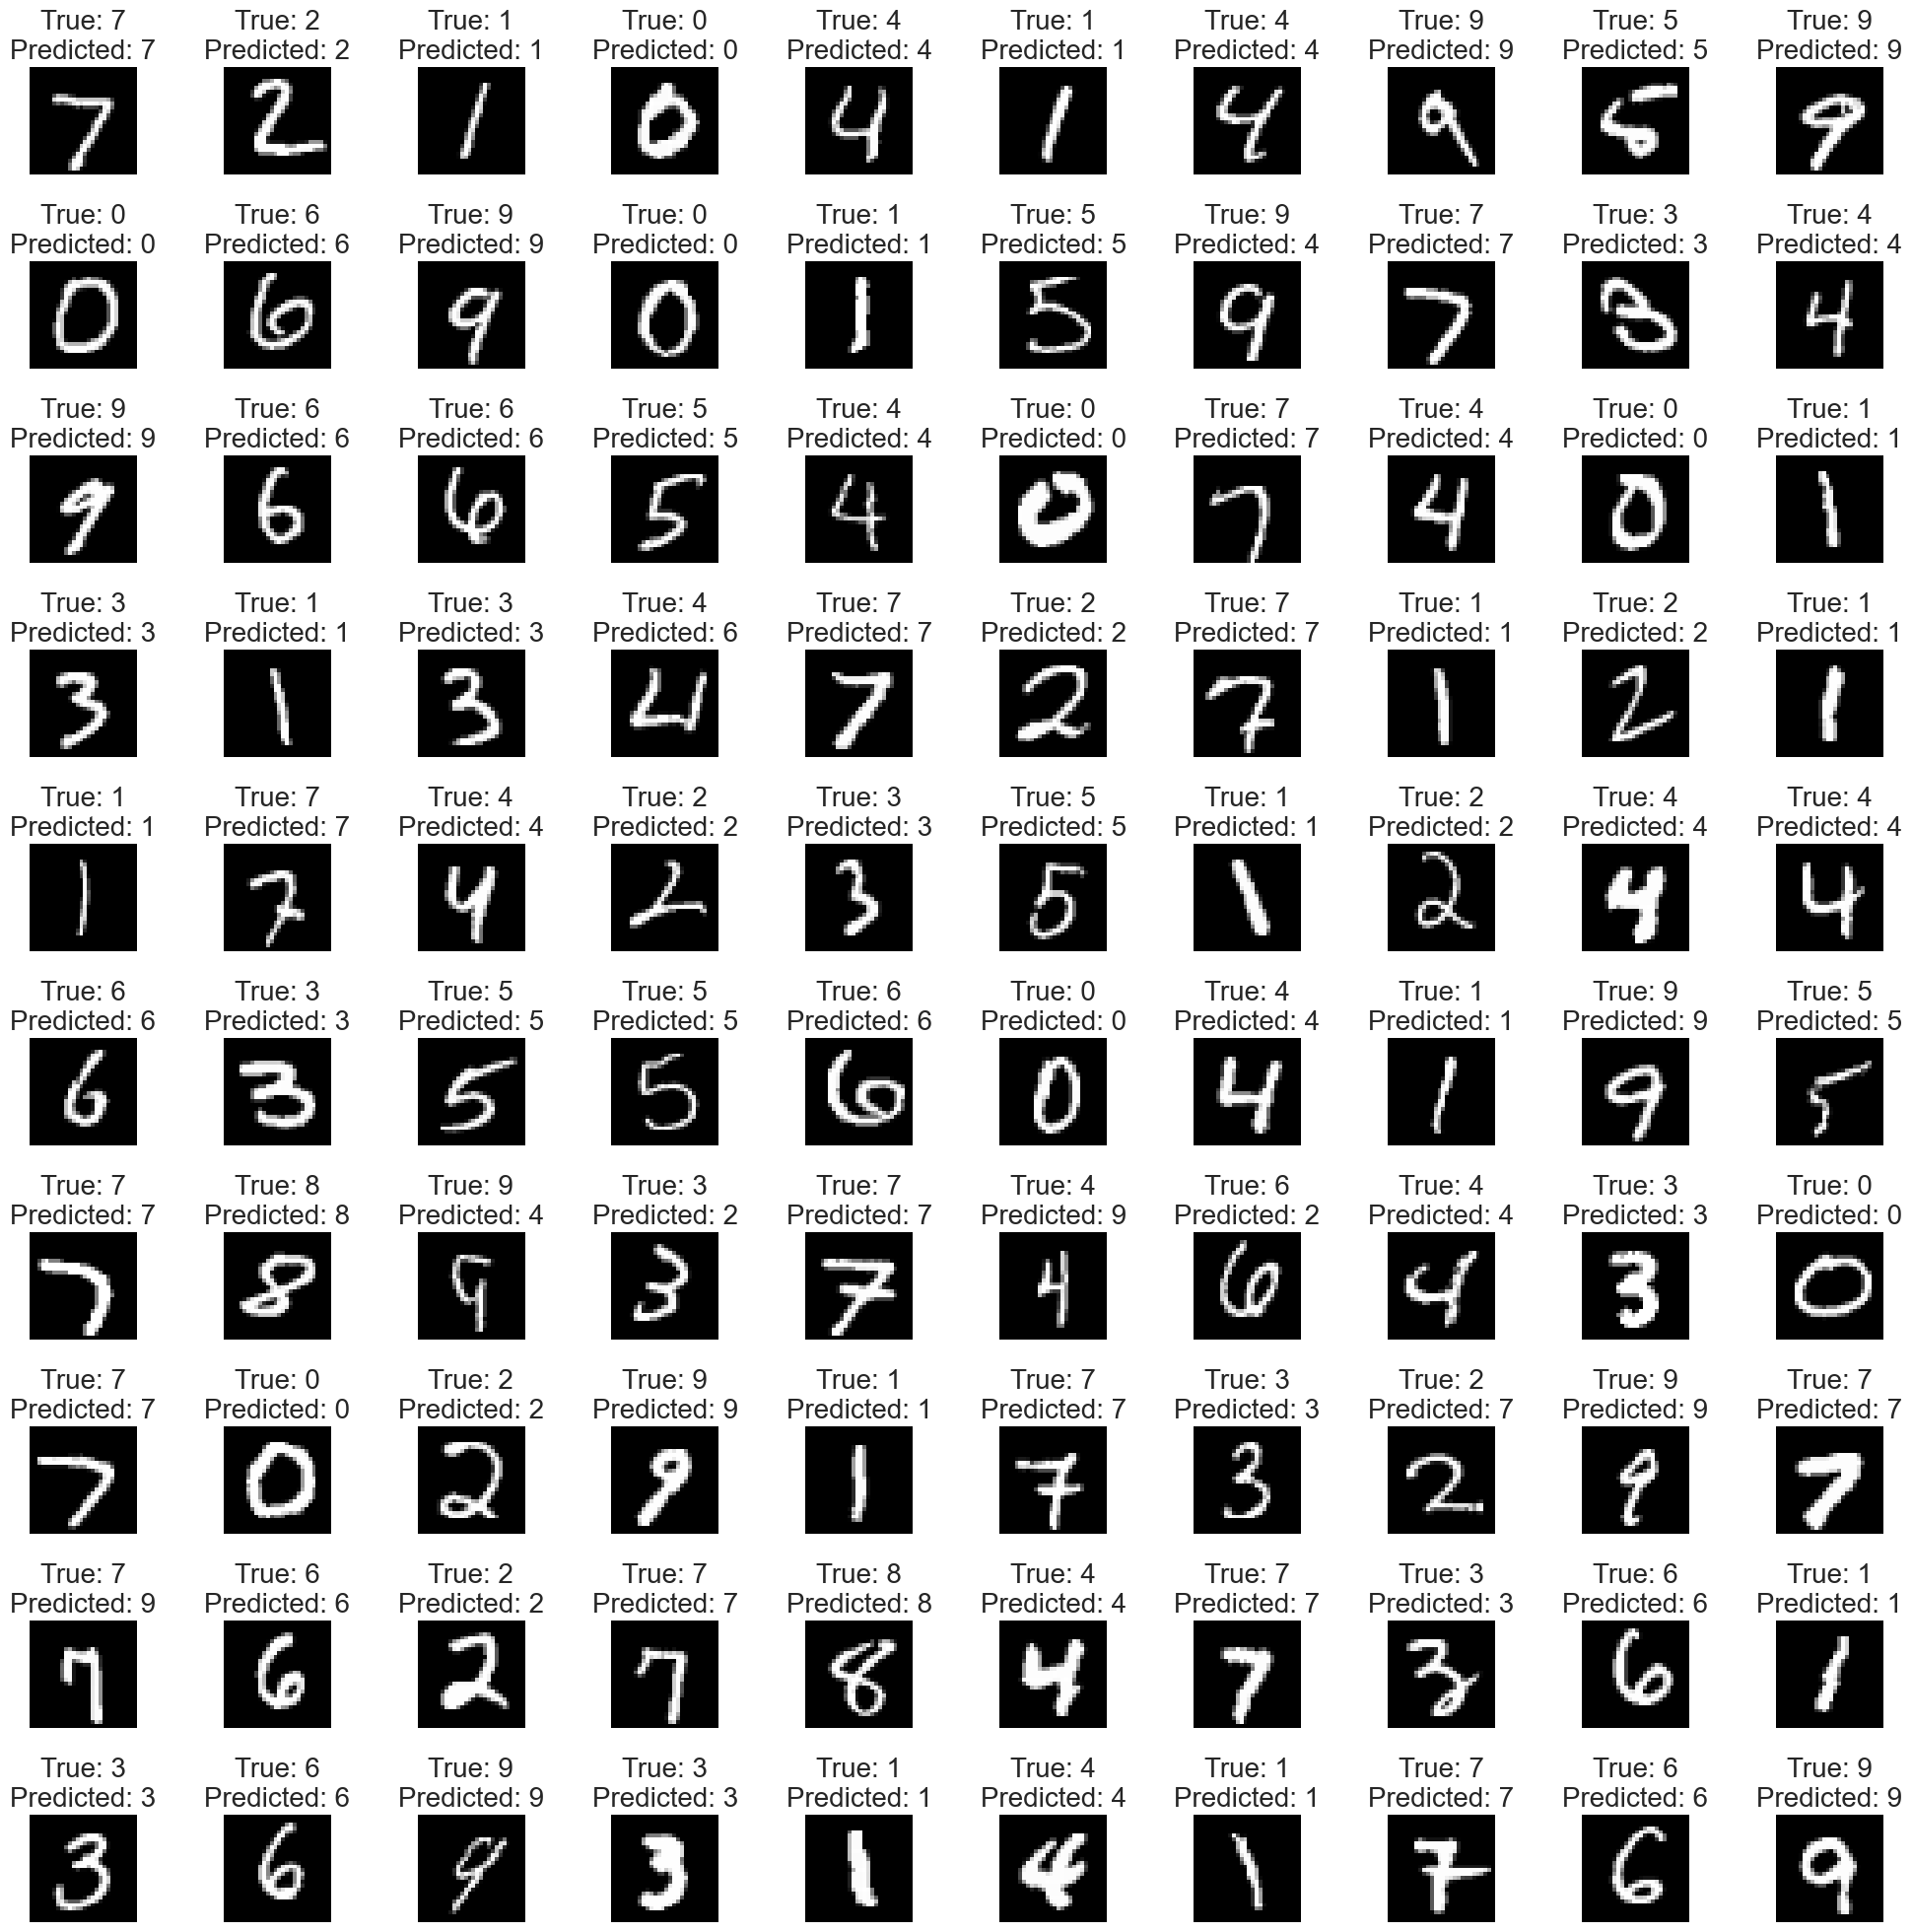

In [276]:
extension(x_test_new, test_y, pred_test, rows=10, cols=10)

As we can see above, the this extension visualizes the neural network predictions. What I found was that the neural networks accuracy is similar to what we predicted above. There are 8 incorrect predictions which is right around what we would have predicted because the accuracy of this neural network is 92%. Additionally, the confusion between numbers was what we expected because many of the confusions were between either 9s and 4s or 7s and 2s. So, this grid is about what I would have expected.